# MCF LP Problem Formulation

## Basic definitions

**Definition**: MCF Net

We define a **net** to be a tuple $(V, E, c, K, D)$ where
    
 - $V$ is a non-empty set of vertices.
 - $G \subseteq V \times V - \{ (v, v) \mid v \in V \}$ is a set of (oriented) edges (self-loops are not included).
 - $c$ is a function $c : E \to \mathbb{R}_{0}^{+}$ which assigns a *capacity* to each edge.
 - $K$ is a set of commodities.
 - $D$ is a set of pairs $(s_i, t_i, d_i)$ for $i \in K$ where:
     - $s_i$ denotes the source node for commodity i
     - $t_i$ denotes the target node for commodity i
     - $d_i$ denotes the demant for commodity i
 
**Definition**: Neighbourhood

For oriented graph $G = (V, E)$ we define for each $v \in V$
$$
\begin{gather*}
N^{+}(v) = \{ u \mid (u, v) \in E \} \\
N^{-}(v) = \{ u \mid (v, u) \in E \}
\end{gather*}
$$
meaning $N^{+}$ is a set of all nodes with an edge comming into $v$ and $N^{-}$ is a set of all nodes for which $v$ has an outcomming edge.

**Definition**: Flow

Let $N = (V, E, c, K, D)$ be a net. Then we define **flow** as a function
$$f : E \times K \to \mathbb{R}^{+}$$
satisfying the following conditions:
 - *the flow does not exceed edge cappacities*
     $$\forall e \in E : \sum\limits_{i \in K} f(e, i) \le c(e)$$
 - *the flow satisfies Kirchhoff's law for each commodity and for all but source and destination nodes*
     $$\forall i \in K : \forall v \in (V - \{s_i, t_i\}) : \sum\limits_{u \in N^{+}(v)} f(uv, i) - \sum\limits_{u \in N^{-}(v)} f(vu, i) = 0$$
     
For simplicity we denote $f_e^k := f(e, k)$.

## LP Formulation

Our formulation will be based on pre-computed maximal flows for each commodity $f^k$. The innitial solution will have the flow on each edge $e$ set as the sum of the flows from each commodity $k$. This can, however, lead to capacities of the edges being violated. We therefore add *violation* variable $\nu_e$ a for each edge $e \in E$ that will represent this violation. We aim to minimize the sum of the violation variables.

In the LP formulation we will have the following **variables**:

 - $f_e^k \in \mathbb{Q}, f_e^k \ge 0$ $\sim$ representing the flow of the commodity $k$ through the edge $e$
 - $\nu_e \in \mathbb{Q}, \nu_e \ge 0$ $\sim$ representing the violation on the edge $e$


**Objective function**
$$ \min \sum_{e \in E} \nu_e$$

**Given the conditions**
    
 - *respecting edge capacities given violation*
 $$\forall e \in E : \sum\limits_{k \in K} f_e^k - \nu_e \le c(e)$$
 - *Kirchhoff's law*
 $$\forall k \in K : \forall v \in (V - \{s_k, t_k\}) :  \sum\limits_{u \in N^{+}(v)} f_{uv}^k - \sum\limits_{u \in N^{-}(v)} f_{vu}^k = 0$$
  
Adding additional variables 


**Objective function**
$$ \max \sum_{e \in E} -\nu_e$$

**Conditions**
$$
\begin{align*}
\forall e \in E &: \sum\limits_{k \in K} f_e^k - \nu_e + \varepsilon_e = c(e) \\
\forall k \in K : \forall v \in (V - \{s_k, t_k\}) &:  \sum\limits_{u \in N^{+}(v)} f_{uv}^k - \sum\limits_{u \in N^{-}(v)} f_{vu}^k = 0 \\
\forall k \in K &: \sum_{\{u, t_k\} \in E} f_{u,t_k}^k = d_k
\end{align*}
$$

**Variables**
$$
\begin{align*}
\forall e \in E : \forall k \in K &: f_e^k \in \mathbb{Q} && f_e^k \ge 0 \\
\forall e \in E &: \nu_e \in \mathbb{Q} && \nu_e \ge 0 \\
\forall e \in E &: \varepsilon_e \in \mathbb{Q} && \varepsilon_e \ge 0
\end{align*}
$$

Denoting $n$ the number of nodes and $m$ the number of edges, we have together $m + |P|n$ conditions and $(|P| + 1)m + (|S| + |D|)|P|$ variables.

In [1]:
# Enable logging
if False:
    import logging

    logging.basicConfig(
        format="%(asctime)s %(levelname)s:%(message)s",
        datefmt="%I:%M:%S",
        level=logging.DEBUG,
    )

### Collecting relevant information from instances

In [2]:
import numpy as np
import sympy as sp
from pathlib import Path
from mcf_simplex_analyzer.load_instance import load_instance
from collections import defaultdict
from fractions import Fraction

from pprint import pprint

# Path to data directory
instances_path = Path("example/")

assert instances_path.exists()


instance_format = "mnetgen"
basename = "dummy"
nod_file = instances_path / (basename + ".nod")
arc_file = instances_path / (basename + ".arc")
sup_file = instances_path / (basename + ".sup")
mut_file = instances_path / (basename + ".mut")

instance = load_instance(instance_format, nod_file, arc_file, sup_file, mut_file)
print(instance.info)

InstanceInfo(products_no=3, nodes_no=7, links_no=26, bundled_links_no=0)


In [3]:
# Collect edge capacities
capacities = {}
commodities = set()

for arc in instance.arcs:
    fromnode, tonode, commodity, cost, individual_capacity, mutual_ptr = arc
    if fromnode == -1 or tonode == -1:
        print(arc)
    
    if commodity != -1:
        commodities.add(commodity)
        
    mutual, capacity = capacities.get((fromnode, tonode), (None, None))
    if mutual_ptr > 0:
        mutual = instance.mutual.mapping[mutual_ptr]
    
    if individual_capacity >= 0:
        capacity = capacity + individual_capacity if capacity is not None else individual_capacity
    
    capacities[(fromnode, tonode)] = (mutual, capacity)

# Account for mutual cappacity
for key in capacities:
    mutual, total = capacities[key]
    capacities[key] = max(mutual, total) if mutual is not None and total is not None else total

print(capacities)
print(len(capacities))
print(commodities)

{(0, 3): mpq(48,1), (0, 4): mpq(115,1), (0, 6): mpq(86,1), (3, 0): mpq(48,1), (3, 2): mpq(100,1), (3, 4): mpq(99,1), (3, 5): mpq(79,1), (4, 0): mpq(115,1), (4, 1): mpq(116,1), (4, 3): mpq(99,1), (4, 5): mpq(66,1), (4, 6): mpq(102,1), (6, 0): mpq(86,1), (6, 1): mpq(114,1), (6, 4): mpq(102,1), (1, 2): mpq(35,1), (1, 4): mpq(116,1), (1, 5): mpq(25,1), (1, 6): mpq(114,1), (2, 1): mpq(35,1), (2, 3): mpq(100,1), (2, 5): mpq(99,1), (5, 1): mpq(25,1), (5, 2): mpq(99,1), (5, 3): mpq(79,1), (5, 4): mpq(66,1)}
26
set()


In [4]:
# Collect source and destination vertices

source = {}
destination = {}

for supply in instance.supply:
    s, t, k, f = supply
    if k < 0:
        print(supply)
        
    if s == -1:
        destination.setdefault(t, dict())[k] = f
        
    if t == -1:
        source.setdefault(s, dict())[k] = f
        
print(source)
print(destination)

{4: {1: mpq(17,1)}, 0: {2: mpq(77,1)}, 3: {3: mpq(63,1)}}
{3: {1: mpq(94,1)}, 2: {2: mpq(61,1)}, 6: {3: mpq(62,1)}}


In [5]:
in_neighbours = {}
out_neighbours = {}

for arc in instance.arcs:
    fromnode, tonode, _, _, _, _ = arc
    in_neighbours.setdefault(tonode, set()).add(fromnode)
    out_neighbours.setdefault(fromnode, set()).add(tonode)

    
print(in_neighbours)
print(out_neighbours)

{3: {0, 2, 4, 5}, 4: {0, 1, 3, 5, 6}, 6: {0, 1, 4}, 0: {3, 4, 6}, 2: {1, 3, 5}, 5: {1, 2, 3, 4}, 1: {2, 4, 5, 6}}
{0: {3, 4, 6}, 3: {0, 2, 4, 5}, 4: {0, 1, 3, 5, 6}, 6: {0, 1, 4}, 1: {2, 4, 5, 6}, 2: {1, 3, 5}, 5: {1, 2, 3, 4}}


# Finding maximal flow for individual commodities

In [6]:
DRAW_GRAPH = False

In [7]:
# Normalize to whole numbers
denoms = ([capacity.denominator for capacity in capacities.values() if capacity is not None] 
          + [ source[s][k].denominator for s in source for k in source[s] ] 
          + [ destination[t][k].denominator for t in destination for k in destination[t] ] 
         )
lcm = np.lcm.reduce(denoms)

# Normalize capacities
for key in capacities:
    capacity = capacities[key]
    if capacity is not None:
        capacities[key] = capacity.numerator * (lcm // capacity.denominator)
        
# Normalize sources
for s in source:
    for k in source[s]:
        supply = source[s][k]
        source[s][k] = supply.numerator * (lcm // supply.denominator)

# Normalize destinations
for t in destination:
    for k in destination[t]:
        demand = destination[t][k]
        destination[t][k] = demand.numerator * (lcm // demand.denominator)
        
network_info = (source, destination, capacities, lcm)

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.DiGraph()
for (u, v) in capacities:
    capacity = capacities[(u, v)]
    if capacity is not None:
        graph.add_edge(u, v, capacity=capacity)
    else:
        graph.add_edge(u, v)
        
if DRAW_GRAPH:
    plt.figure(figsize=(13, 8))
    nx.draw_kamada_kawai(graph, node_size=100)

In [9]:
import pprint

def gather_sources(network_info, graph, commodity):
    (source, _, capacities, _) = network_info

    for s in source:
        if commodity in source[s]:
            supply = source[s][commodity].numerator
            graph.add_edge("Source", s, capacity=supply)

            
def gather_destinations(network_info, graph, commodity):
    (_, destination, capacities, _) = network_info
    
    commodity_destinations = []
    for t in destination:
        if commodity in destination[t]: 
            demand = destination[t][commodity]      
            graph.add_edge(t, "Destination", capacity=demand)
            
def get_percantage_full(graph, flow_dict, u, v):
    max_capacity = graph.get_edge_data(u, v).get('capacity', None)
    
    if max_capacity is None:
        return 0
    
    perc = flow_dict[u][v] / max_capacity
    
    return perc

In [10]:
import matplotlib.cm as cm
from matplotlib.colors import Normalize

def draw_network(graph, flow_dict):
    plt.figure(figsize=(10, 7))
    
    percentage_full=np.array([ float(get_percantage_full(graph, flow_dict, u, v)) for (u,v) in graph.edges])
    norm = Normalize(vmin=0, vmax=1)
    colors = cm.viridis(norm(percentage_full))
    colors[ percentage_full > 1 ] = [1, 0, 0, 1]
    
    
    # DEBUG
    #print(percentage_full)
    
    nx.draw_kamada_kawai(
        graph,
        
        with_labels=True,
        font_size=16,
        font_weight="bold",
        
        node_size=500,
        nodelist=graph.nodes,
        node_color=['lightblue' for _ in graph.nodes],
        
        #edge_color=percentage_full,
        edge_color=colors,
        width=2,
        connectionstyle="arc3,rad=0.1"
    )

MAX_ITER = 4
print(f"Computing first {MAX_ITER} networks ...")

for commodity in range(1, min(instance.info.products_no + 1, MAX_ITER + 1)):
    commodity_graph = graph.copy()
    
    gather_sources(network_info, commodity_graph, commodity)
    gather_destinations(network_info, commodity_graph, commodity)

    # Compute maximal flow     
    flow_value, flow_dict = nx.maximum_flow(commodity_graph, "Source", "Destination")
    
    # DEBUG
    # print(flow_value)
    # print(pprint.pprint(flow_dict))
    
    if DRAW_GRAPH:
        draw_network(commodity_graph, flow_dict)

Computing first 4 networks ...


In [11]:
flow_sum = {}

acc = 0
for commodity in range(1, instance.info.products_no + 1):
    print("Computing flow for commodity", commodity)
    
    commodity_graph = graph.copy()
    
    gather_sources(network_info, commodity_graph, commodity)
    gather_destinations(network_info, commodity_graph, commodity)

    # Compute maximal flow     
    flow_value, flow_dict = nx.maximum_flow(commodity_graph, "Source", "Destination")
    
    for u in flow_dict:
        if u == "Source":
            continue
            
        for v in flow_dict[u]:
            if v == "Destination":
                continue
                
            d = flow_sum.setdefault(u, {})
            d[v] = d.get(v, 0) + flow_dict[u][v]
            
    # DEBUG
    acc += flow_value
    # print(flow_value)
    # print(pprint.pprint(flow_dict))

print(acc)
flow_sum

Computing flow for commodity 1
Computing flow for commodity 2
Computing flow for commodity 3
140


{0: {3: mpz(32), 4: mpz(29), 6: mpz(47)},
 3: {0: mpz(47), 2: mpz(61), 4: mpz(15), 5: 0},
 4: {0: 0, 1: 0, 3: mpz(46), 5: 0, 6: mpz(15)},
 6: {0: 0, 1: 0, 4: 0},
 2: {1: 0, 3: 0, 5: 0},
 5: {1: 0, 2: 0, 3: 0, 4: 0},
 1: {2: 0, 4: 0, 5: 0, 6: 0}}

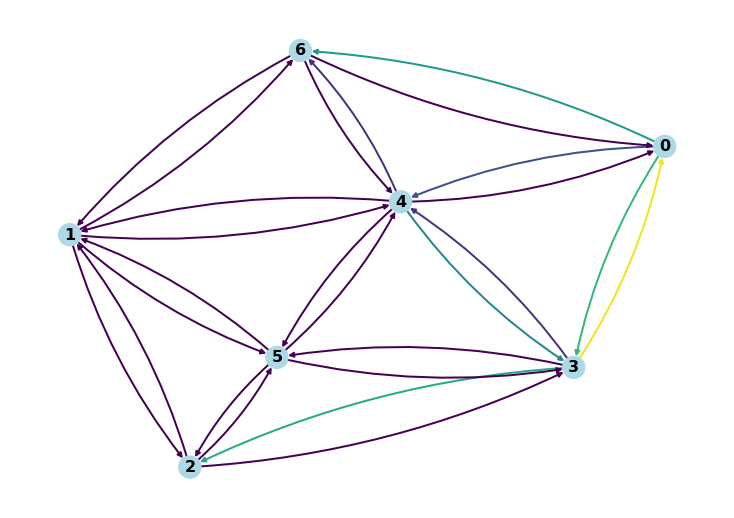

In [12]:
draw_network(graph, flow_sum)

In [13]:
from mcf_simplex_analyzer.formulate import formulate_concurrent_flow_problem

network_info, max_flow_sum = formulate_concurrent_flow_problem(instance)

Invalid mutual ptr:
(0, 3, -1, mpq(-1,1), mpq(48,1), 0)
Invalid mutual ptr:
(0, 4, -1, mpq(-1,1), mpq(115,1), 0)
Invalid mutual ptr:
(0, 6, -1, mpq(-1,1), mpq(86,1), 0)
Invalid mutual ptr:
(3, 0, -1, mpq(-1,1), mpq(48,1), 0)
Invalid mutual ptr:
(3, 2, -1, mpq(-1,1), mpq(100,1), 0)
Invalid mutual ptr:
(3, 4, -1, mpq(-1,1), mpq(99,1), 0)
Invalid mutual ptr:
(3, 5, -1, mpq(-1,1), mpq(79,1), 0)
Invalid mutual ptr:
(4, 0, -1, mpq(-1,1), mpq(115,1), 0)
Invalid mutual ptr:
(4, 1, -1, mpq(-1,1), mpq(116,1), 0)
Invalid mutual ptr:
(4, 3, -1, mpq(-1,1), mpq(99,1), 0)
Invalid mutual ptr:
(4, 5, -1, mpq(-1,1), mpq(66,1), 0)
Invalid mutual ptr:
(4, 6, -1, mpq(-1,1), mpq(102,1), 0)
Invalid mutual ptr:
(6, 0, -1, mpq(-1,1), mpq(86,1), 0)
Invalid mutual ptr:
(6, 1, -1, mpq(-1,1), mpq(114,1), 0)
Invalid mutual ptr:
(6, 4, -1, mpq(-1,1), mpq(102,1), 0)
Invalid mutual ptr:
(1, 2, -1, mpq(-1,1), mpq(35,1), 0)
Invalid mutual ptr:
(1, 4, -1, mpq(-1,1), mpq(116,1), 0)
Invalid mutual ptr:
(1, 5, -1, mpq(-1,1)

In [14]:
import attr
import pulp


def solve_for(instance, network_info, y=1):
    model = pulp.LpProblem(name="concurrent_flow", sense=pulp.LpMinimize)

    variables = {"flow": {}, "violation": {}}
    for commodity in range(1, instance.info.products_no + 1):
        for u in network_info.capacities:
            for v in network_info.capacities[u]:
                variables["flow"][(u, v, commodity)] = pulp.LpVariable(
                    name="f_({}-{})^{}".format(u, v, commodity), lowBound=0
                )

    # Violation
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            variables["violation"][(u, v)] = pulp.LpVariable(
                name="v_({}-{})".format(u, v), lowBound=0
            )

    # Objective
    model += pulp.lpSum(
        [
            variables["violation"][(u, v)]
            for u in network_info.capacities
            for v in network_info.capacities[u]
        ]
    )

    # Edges
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            model += (
                pulp.lpSum(
                    [
                        variables["flow"][(u, v, commodity)]
                        for commodity in range(1, instance.info.products_no + 1)
                    ]
                )
                - variables["violation"][(u, v)]
                <= network_info.capacities[u][v]
            )

    vertices = set()
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            vertices.add(u)
            vertices.add(v)

    # Kirchhof
    for commodity in range(1, instance.info.products_no + 1):
        for vertex in vertices:
            if (
                vertex in network_info.sources
                and commodity in network_info.sources[vertex]
            ):
                continue

            if (
                vertex in network_info.destinations
                and commodity in network_info.destinations[vertex]
            ):
                continue

            outgoing = pulp.lpSum(
                [
                    variables["flow"][(vertex, u, commodity)]
                    for u in network_info.capacities.get(vertex, [])
                ]
            )

            incomming = pulp.lpSum(
                [
                    variables["flow"][(u, vertex, commodity)]
                    for u in network_info.capacities
                    if vertex in network_info.capacities.get(u, {})
                ]
            )

            model += outgoing - incomming == 0

    for destination in network_info.destinations:
        for commodity in network_info.destinations[destination]:
            incomming = pulp.lpSum(
                [
                    variables["flow"][(u, destination, commodity)]
                    for u in network_info.capacities
                    if destination in network_info.capacities.get(u, {})
                ]
            )
            model += incomming >= y * network_info.destinations[destination][commodity]

    model.solve()

    return model, variables

In [15]:
y = 1
y_max = None
y_min = 0

eps = 1e-6

# Increase
ys = []
opts = []
while True:
    model, variables = solve_for(instance, network_info, y)
    opt = sum(var.value() for key, var in variables["violation"].items())
    print("opt:", opt)
    ys.append(y)
    opts.append(opt)

    if opt > eps:
        y_max = y
        new_y = (y_min + y_max) / 2

    if abs(opt) <= eps:
        y_min = y
        if y_max is None:
            new_y = 2 * y
        else:
            new_y = (y_min + y_max) / 2
            
    if abs(y - new_y) < 0.001 and opt == 0:
        break
        
    y = new_y

    print("New y:", y)

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/davidkubek/.cache/pypoetry/virtualenvs/mcf-simplex-analyzer-RAO3Mfjo-py3.9/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/linux/64/cbc /tmp/b8ce198f4ff94281803d76efbeda9b76-pulp.mps branch printingOptions all solution /tmp/b8ce198f4ff94281803d76efbeda9b76-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 49 COLUMNS
At line 302 RHS
At line 347 BOUNDS
At line 348 ENDATA
Problem MODEL has 44 rows, 104 columns and 226 elements
Coin0008I MODEL read with 0 errors
Presolve 44 (0) rows, 103 (-1) columns and 225 (-1) elements
Perturbing problem by 0.001% of 1 - largest nonzero change 1.0617779e-06 ( 0.00010617779%) - largest zero change 1.059631e-06
0  Obj 0 Primal inf 316 (4)
9  Obj 0.0002946036
Optimal - objective value 0
After Postsolve, objective 0, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 0 - 9 iterations time 0.002, Presolve 0.00
Opti

In [16]:
ys

[1,
 2,
 4,
 3.0,
 2.5,
 2.75,
 2.875,
 2.9375,
 2.96875,
 2.953125,
 2.9609375,
 2.96484375,
 2.966796875]

In [17]:
opts

[0.0, 0.0, 160.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.15625, 0.0, 0.0, 0.0, 0.0]

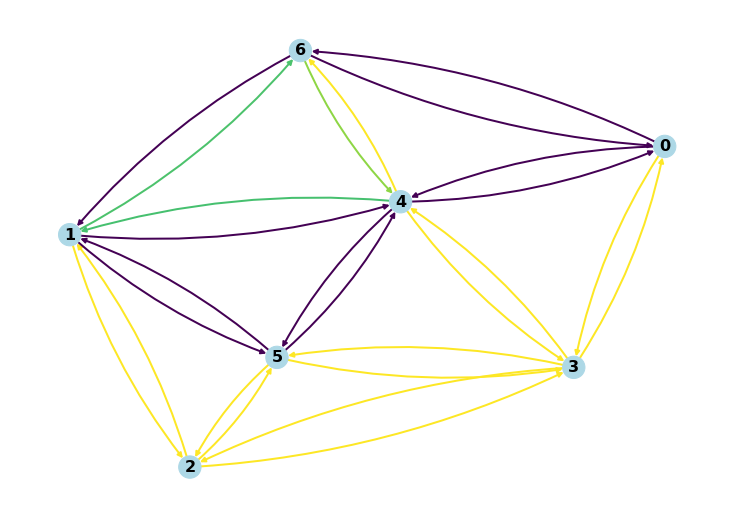

In [18]:
flow_sum = {}
for u in network_info.capacities:
    for v in network_info.capacities[u]:
        flow_sum.setdefault(u, {})[v] = round(
            sum(
                variables["flow"][(u, v, commodity)].value()
                for commodity in range(1, instance.info.products_no + 1)
                if (u, v, commodity) in variables["flow"]
            ),
            4,
        )

for u in flow_sum:
    for v in flow_sum[u]:
        if flow_sum[u][v] > network_info.capacities[u][v]:
            print(u, v, flow_sum[u][v] - network_info.capacities[u][v])

draw_network(graph, flow_sum)

In [19]:
import sympy
from scipy.sparse import lil_matrix

from mcf_simplex_analyzer.fractionarray import FractionArray
from mcf_simplex_analyzer.simplex import LPModel, lp_sum


def formulate_lp(instance, network_info, y=1):
    model = LPModel(name="concurrent_flow")

    variables = {"flow": {}, "violation": {}}
    for commodity in range(1, instance.info.products_no + 1):
        for u in network_info.capacities:
            for v in network_info.capacities[u]:
                variables["flow"][(u, v, commodity)] = model.new_variable(
                    name="f_({}-{})^{}".format(u, v, commodity)
                )

    # Violation
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            variables["violation"][(u, v)] = model.new_variable(
                name="v_({}-{})".format(u, v)
            )

    # Objective
    model.objective_function = lp_sum(
        [
            -variables["violation"][(u, v)]
            for u in network_info.capacities
            for v in network_info.capacities[u]
        ]
    )

    # Edges
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            model.constraints.append(
                lp_sum(
                    [
                        variables["flow"][(u, v, commodity)]
                        for commodity in range(1, instance.info.products_no + 1)
                    ]
                )
                - variables["violation"][(u, v)]
                <= network_info.capacities[u][v]
            )

    vertices = set()
    for u in network_info.capacities:
        for v in network_info.capacities[u]:
            vertices.add(u)
            vertices.add(v)

    # Kirchhof
    for commodity in range(1, instance.info.products_no + 1):
        for vertex in vertices:
            if (
                vertex in network_info.sources
                and commodity in network_info.sources[vertex]
            ):
                continue

            if (
                vertex in network_info.destinations
                and commodity in network_info.destinations[vertex]
            ):
                continue

            outgoing = lp_sum(
                [
                    variables["flow"][(vertex, u, commodity)]
                    for u in network_info.capacities.get(vertex, [])
                ]
            )

            incomming = lp_sum(
                [
                    variables["flow"][(u, vertex, commodity)]
                    for u in network_info.capacities
                    if vertex in network_info.capacities.get(u, {})
                ]
            )

            model.constraints.append(outgoing - incomming == 0)

    for destination in network_info.destinations:
        for commodity in network_info.destinations[destination]:
            incomming = lp_sum(
                [
                    variables["flow"][(u, destination, commodity)]
                    for u in network_info.capacities
                    if destination in network_info.capacities.get(u, {})
                ]
            )
            model.constraints.append(
                incomming >= y * network_info.destinations[destination][commodity]
            )

    return model, variables

In [20]:
model, variables = formulate_lp(instance, network_info, 1)

In [21]:
variables

{'flow': {(0, 3, 1): Variable(index=0, name='f_(0-3)^1'),
  (0, 4, 1): Variable(index=1, name='f_(0-4)^1'),
  (0, 6, 1): Variable(index=2, name='f_(0-6)^1'),
  (3, 0, 1): Variable(index=3, name='f_(3-0)^1'),
  (3, 2, 1): Variable(index=4, name='f_(3-2)^1'),
  (3, 4, 1): Variable(index=5, name='f_(3-4)^1'),
  (3, 5, 1): Variable(index=6, name='f_(3-5)^1'),
  (4, 0, 1): Variable(index=7, name='f_(4-0)^1'),
  (4, 1, 1): Variable(index=8, name='f_(4-1)^1'),
  (4, 3, 1): Variable(index=9, name='f_(4-3)^1'),
  (4, 5, 1): Variable(index=10, name='f_(4-5)^1'),
  (4, 6, 1): Variable(index=11, name='f_(4-6)^1'),
  (6, 0, 1): Variable(index=12, name='f_(6-0)^1'),
  (6, 1, 1): Variable(index=13, name='f_(6-1)^1'),
  (6, 4, 1): Variable(index=14, name='f_(6-4)^1'),
  (1, 2, 1): Variable(index=15, name='f_(1-2)^1'),
  (1, 4, 1): Variable(index=16, name='f_(1-4)^1'),
  (1, 5, 1): Variable(index=17, name='f_(1-5)^1'),
  (1, 6, 1): Variable(index=18, name='f_(1-6)^1'),
  (2, 1, 1): Variable(index=19, n

In [31]:
network_info.capacities[4][3]

mpq(99,1)

In [23]:
from mcf_simplex_analyzer.simplex import RevisedSimplex
import mcf_simplex_analyzer.fractionarray.sparse as fas

simplex = RevisedSimplex.instantiate(model)
np.count_nonzero(simplex.base)
#print(fas.csc_to_dense(fas.csc_select_columns(simplex.table, [69])))
simplex.objective_function

0
-217
147 76
1
-217
145 73
2
-217
144 70
3
-217
76 74
4
-155
150 65
5
-155
146 63
6
-155
143 54
7
-155
141 49
8
-94
149 47
9
-94
138 43
10
-94
142 39
11
-94
140 37
12
-94
139 32
13
-94
136 25
14
-94
25 24
15
-94
135 21
16
-94
134 17
17
-94
137 14
18
-94
14 13
19
-69
121 11
20
-42
117 95
21
-15
128 91
22
0
148 102
23
0
133 2
24


FractionArray(data=[mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(-1,1) mpq(-1,1)
 mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1)
 mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1)
 mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(-1,1)
 mpq(-1,1) mpq(-1,1) mpq(-1,1) mpq(0

In [39]:
vs = np.where(simplex.base[:77])[0]
vals = simplex.eta_file.ftran(simplex.right_hand_side)
for var, val in zip(vs, vals):
    print(var, val)

2 0
11 94
13 94
17 94
21 0
24 94
32 0
37 0
39 0
43 0
47 61
49 61
54 0
63 0
65 62
70 62
73 0
74 0


In [25]:
y = simplex.eta_file.btran(simplex.objective_function[simplex._base_indices])
o = simplex._compute_objective(y)
o[69]

mpq(1,1)

In [33]:
import mcf_simplex_analyzer.fractionarray.sparse as fas

columns = np.where(simplex.base)[0]
T = fas.csc_to_dense(fas.csc_select_columns(simplex.table, columns))
T

FractionArray(data=[[mpq(0,1) mpq(0,1) mpq(0,1) ... mpq(0,1) mpq(0,1) mpq(0,1)]
 [mpq(0,1) mpq(0,1) mpq(0,1) ... mpq(0,1) mpq(0,1) mpq(0,1)]
 [mpq(1,1) mpq(0,1) mpq(0,1) ... mpq(0,1) mpq(0,1) mpq(0,1)]
 ...
 [mpq(0,1) mpq(0,1) mpq(0,1) ... mpq(0,1) mpq(0,1) mpq(0,1)]
 [mpq(0,1) mpq(0,1) mpq(0,1) ... mpq(0,1) mpq(0,1) mpq(0,1)]
 [mpq(0,1) mpq(0,1) mpq(0,1) ... mpq(0,1) mpq(0,1) mpq(0,1)]])

In [27]:
y = 1
y_max = None
y_min = 0

eps = 1e-6

# Increase
ys = []
opts = []
while True:
    model, variables = formulate_lp(instance, network_info, y)
    simplex = RevisedSimplex.instantiate(model)
    ans = simplex.solve()
    opt = ans.value
    print("opt:", opt)
    ys.append(y)
    opts.append(opt)

    if opt > eps:
        y_max = y
        new_y = (y_min + y_max) / 2

    if abs(opt) <= eps:
        y_min = y
        if y_max is None:
            new_y = 2 * y
        else:
            new_y = (y_min + y_max) / 2
            
    if abs(y - new_y) < 0.1 and opt == 0:
        break
        
    y = new_y

    print("New y:", y)

0
-217
147 76
1
-217
145 73
2
-217
144 70
3
-217
76 74
4
-155
150 65
5
-155
146 63
6
-155
143 54
7
-155
141 49
8
-94
149 47
9
-94
138 43
10
-94
142 39
11
-94
140 37
12
-94
139 32
13
-94
136 25
14
-94
25 24
15
-94
135 21
16
-94
134 17
17
-94
137 14
18
-94
14 13
19
-69
121 11
20
-42
117 95
21
-15
128 91
22
0
148 102
23
0
133 2
24
0
FractionArray(data=[mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(-1,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)])
87 1 FractionArray(data=[mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1) mpq(0,1)
 

TypeError: '>' not supported between instances of 'NoneType' and 'float'

In [ ]:
import cProfile
import pstats
from pstats import SortKey

#cProfile.run("RevisedSimplex.instantiate(model)", 'restats')